In [86]:
import numpy as np 
import pandas as pd 
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
Name = "Roberto Romo"

# Diamonds

#### Goal: To find a model that gives the price of a diamond based on its features





Index|
--- | 
[The data](#data)  |
[EDA](#eda) |
[EDA Plots](#plots) |
[Model 1 (linear regression)](#m1) |
[Model 2 (linear regression - improved)](#m2)|
[Model 3 (ridge - extra)](#ridge)|
[Results](#results) |

## The Data <a name="data"></a>

In [88]:
diamonds = pd.read_csv("../Diamonds/diamonds_data.csv")


test = {'carat': [.71, .83, .5, .39, .32, .9, .51, 1.12, .4, .36], 
     'cut': ['Good', 'Ideal', 'Ideal', 'Premium', 'Premium', 'Good', 'Ideal', 'Ideal', 'Ideal', 'Premium'], 
     'color': ['I', 'G', 'E', 'J', 'G', 'F', 'D', 'G', 'G', 'I'],
     'clarity': ['VVS2', 'VS1', 'VS2', 'VS1', 'VS1', 'SI2', 'VS1', 'VVS2', 'VVS2', 'VS2'], 
     'depth': [63.1, 62.1, 61.5, 61.6, 62.1, 63.3, 60.9, 62.1, 62.4, 62.7], 
     'table': [58, 55, 55, 59, 56, 57, 57, 54.8, 56, 59], 
     'x': [5.64, 6.02, 5.11, 4.67, 4.43, 6.08, 5.2, 6.64, 4.72, 4.54], 
     'y': [5.71, 6.05, 5.16, 4.71, 4.4, 6.14, 5.17, 6.66, 4.74, 4.58], 
     'z': [3.58, 3.75, 3.16, 2.89, 2.74, 3.87, 3.16, 4.13, 2.95, 2.86],}

test_diamonds = pd.DataFrame(data = test)

print(diamonds.columns.values)
print(test_diamonds.columns.values)

['carat' 'cut' 'color' 'clarity' 'depth' 'table' 'price' 'x' 'y' 'z']
['carat' 'clarity' 'color' 'cut' 'depth' 'table' 'x' 'y' 'z']


## EDA <a name="eda"></a>

In [89]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000
mean,0.797976,61.749325,57.457328,3933.054942,5.731236,5.734601,3.538776
std,0.474035,1.432711,2.234578,3989.628569,1.121807,1.142184,0.705729
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5325.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


##### NOTE There is some incosistency with the data. Some 'x', 'y' , and 'z' columns have a minimum value of zero, these rows will be removed.

In [90]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53930 entries, 0 to 53929
Data columns (total 10 columns):
carat      53930 non-null float64
cut        53930 non-null object
color      53930 non-null object
clarity    53930 non-null object
depth      53930 non-null float64
table      53930 non-null float64
price      53930 non-null int64
x          53930 non-null float64
y          53930 non-null float64
z          53930 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


##### NOTE: The 'cut', 'color', and 'clartity' columns are of type object, to incorporate them into our model we will map those objects to integers based on their ordering from 1 being the lowest to len(column) being the highest.

### Reusable Pipleline that: <a name="pipeline"></a>


* Assumes data has columns cut, color, clarity, x, y, z
* Removes rows with x, y, z < 0
* Maps non-int/float columns to integers

In [91]:
def process_data(data):
    
    #clean data 
    data = data[( data['x'] > 0) & ( data['y'] > 0) & ( data['z'] > 0)]
    
    #transform data
    data['cut'] = data['cut'].map({'Fair':1,'Good':2,'Very Good':3,'Premium':4,'Ideal':5})
    data['color'] = data['color'].map({'J':1,'I':2,'H':3,'G':4,'F':5,'E':6,'D':7})
    data['clarity'] = data['clarity'].map({'I3':1,'I2':2,'I1':3,'SI2':4,'SI1':5,'VS2':6,'VS1':7,'VVS2':8, 'VVS1':9, 'IF':10, 'FL':11})
    
    return data

In [92]:
#the rows with zero's in the x,y,z columns
zeros = diamonds[( diamonds['x'] == 0) | ( diamonds['y']== 0) | ( diamonds['z'] == 0)]

diamonds = process_data(diamonds)
test_diamonds = process_data(test_diamonds)

#check len of data is consistent
assert len(diamonds) == (53930 - len(zeros))
assert len(test_diamonds == 10)

#check shape of data is consistent
assert diamonds.shape == (len(diamonds), 10)
assert test_diamonds.shape == (10, 9)

In [93]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53910 entries, 0 to 53929
Data columns (total 10 columns):
carat      53910 non-null float64
cut        53910 non-null int64
color      53910 non-null int64
clarity    53910 non-null int64
depth      53910 non-null float64
table      53910 non-null float64
price      53910 non-null int64
x          53910 non-null float64
y          53910 non-null float64
z          53910 non-null float64
dtypes: float64(6), int64(4)
memory usage: 4.5 MB


In [94]:
diamonds.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53910.000000,53910.000000,53910.000000,53910.000000,53910.000000,53910.000000,53910.000000,53910.000000,53910.000000,53910.000000
mean,0.797734,3.904192,4.406066,6.051363,61.749434,57.456978,3931.248210,5.731706,5.734962,3.540089
std,0.473819,1.116572,1.701248,1.647049,1.432420,2.234152,3987.469164,1.119469,1.140175,0.702560
min,0.200000,1.000000,1.000000,3.000000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,3.000000,3.000000,5.000000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,4.000000,4.000000,6.000000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,5.000000,6.000000,7.000000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,5.010000,5.000000,7.000000,10.000000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [95]:
test_diamonds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 9 columns):
carat      10 non-null float64
clarity    10 non-null int64
color      10 non-null int64
cut        10 non-null int64
depth      10 non-null float64
table      10 non-null float64
x          10 non-null float64
y          10 non-null float64
z          10 non-null float64
dtypes: float64(6), int64(3)
memory usage: 800.0 bytes


In [96]:
test_diamonds.describe()

,carat,clarity,color,cut,depth,table,x,y,z
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.604000,6.800000,3.900000,4.100000,62.180000,56.680000,5.305000,5.332000,3.309000
std,0.271506,1.229273,1.852926,1.197219,0.736056,1.592203,0.756575,0.767547,0.486586
min,0.320000,4.000000,1.000000,2.000000,60.900000,54.800000,4.430000,4.400000,2.740000
25%,0.392500,6.250000,2.500000,4.000000,61.725000,55.250000,4.682500,4.717500,2.905000
50%,0.505000,7.000000,4.000000,4.500000,62.100000,56.500000,5.155000,5.165000,3.160000
75%,0.800000,7.750000,4.750000,5.000000,62.625000,57.750000,5.925000,5.965000,3.707500
max,1.120000,8.000000,7.000000,5.000000,63.300000,59.000000,6.640000,6.660000,4.130000


## EDA Plots <a name="plots"></a>

The following plots intend to explore and understand the data. Better said, the plots explore relationships (i.e. correlations) between features of the diamonds that will later help us create a model

######  Not all of the plots influenced the final model but they were left to show thought progress and what relationships I was exploring. Takeaways are annotated under each plot.

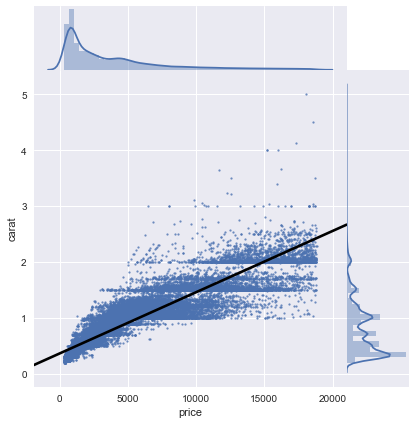

In [97]:
sns.jointplot(
    x='price', 
    y='carat', 
    data=diamonds,
    stat_func=None,
    kind="reg",
    space=0,
    scatter_kws={
        's': 5,
    },
    line_kws={
        'color': 'black'
    }
)

#### In the above plot we notice a positive correlation between price and carat

In [98]:
diamonds['price'].mean()

3931.2482099795957

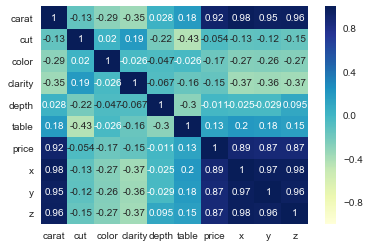

In [99]:
sns.heatmap(diamonds.corr(), annot=True, cmap="YlGnBu")

##### X, Y ,  Z, and Carat have strong correlation. Price. Cut, Color, Clarity, and Depth have weak correlation 

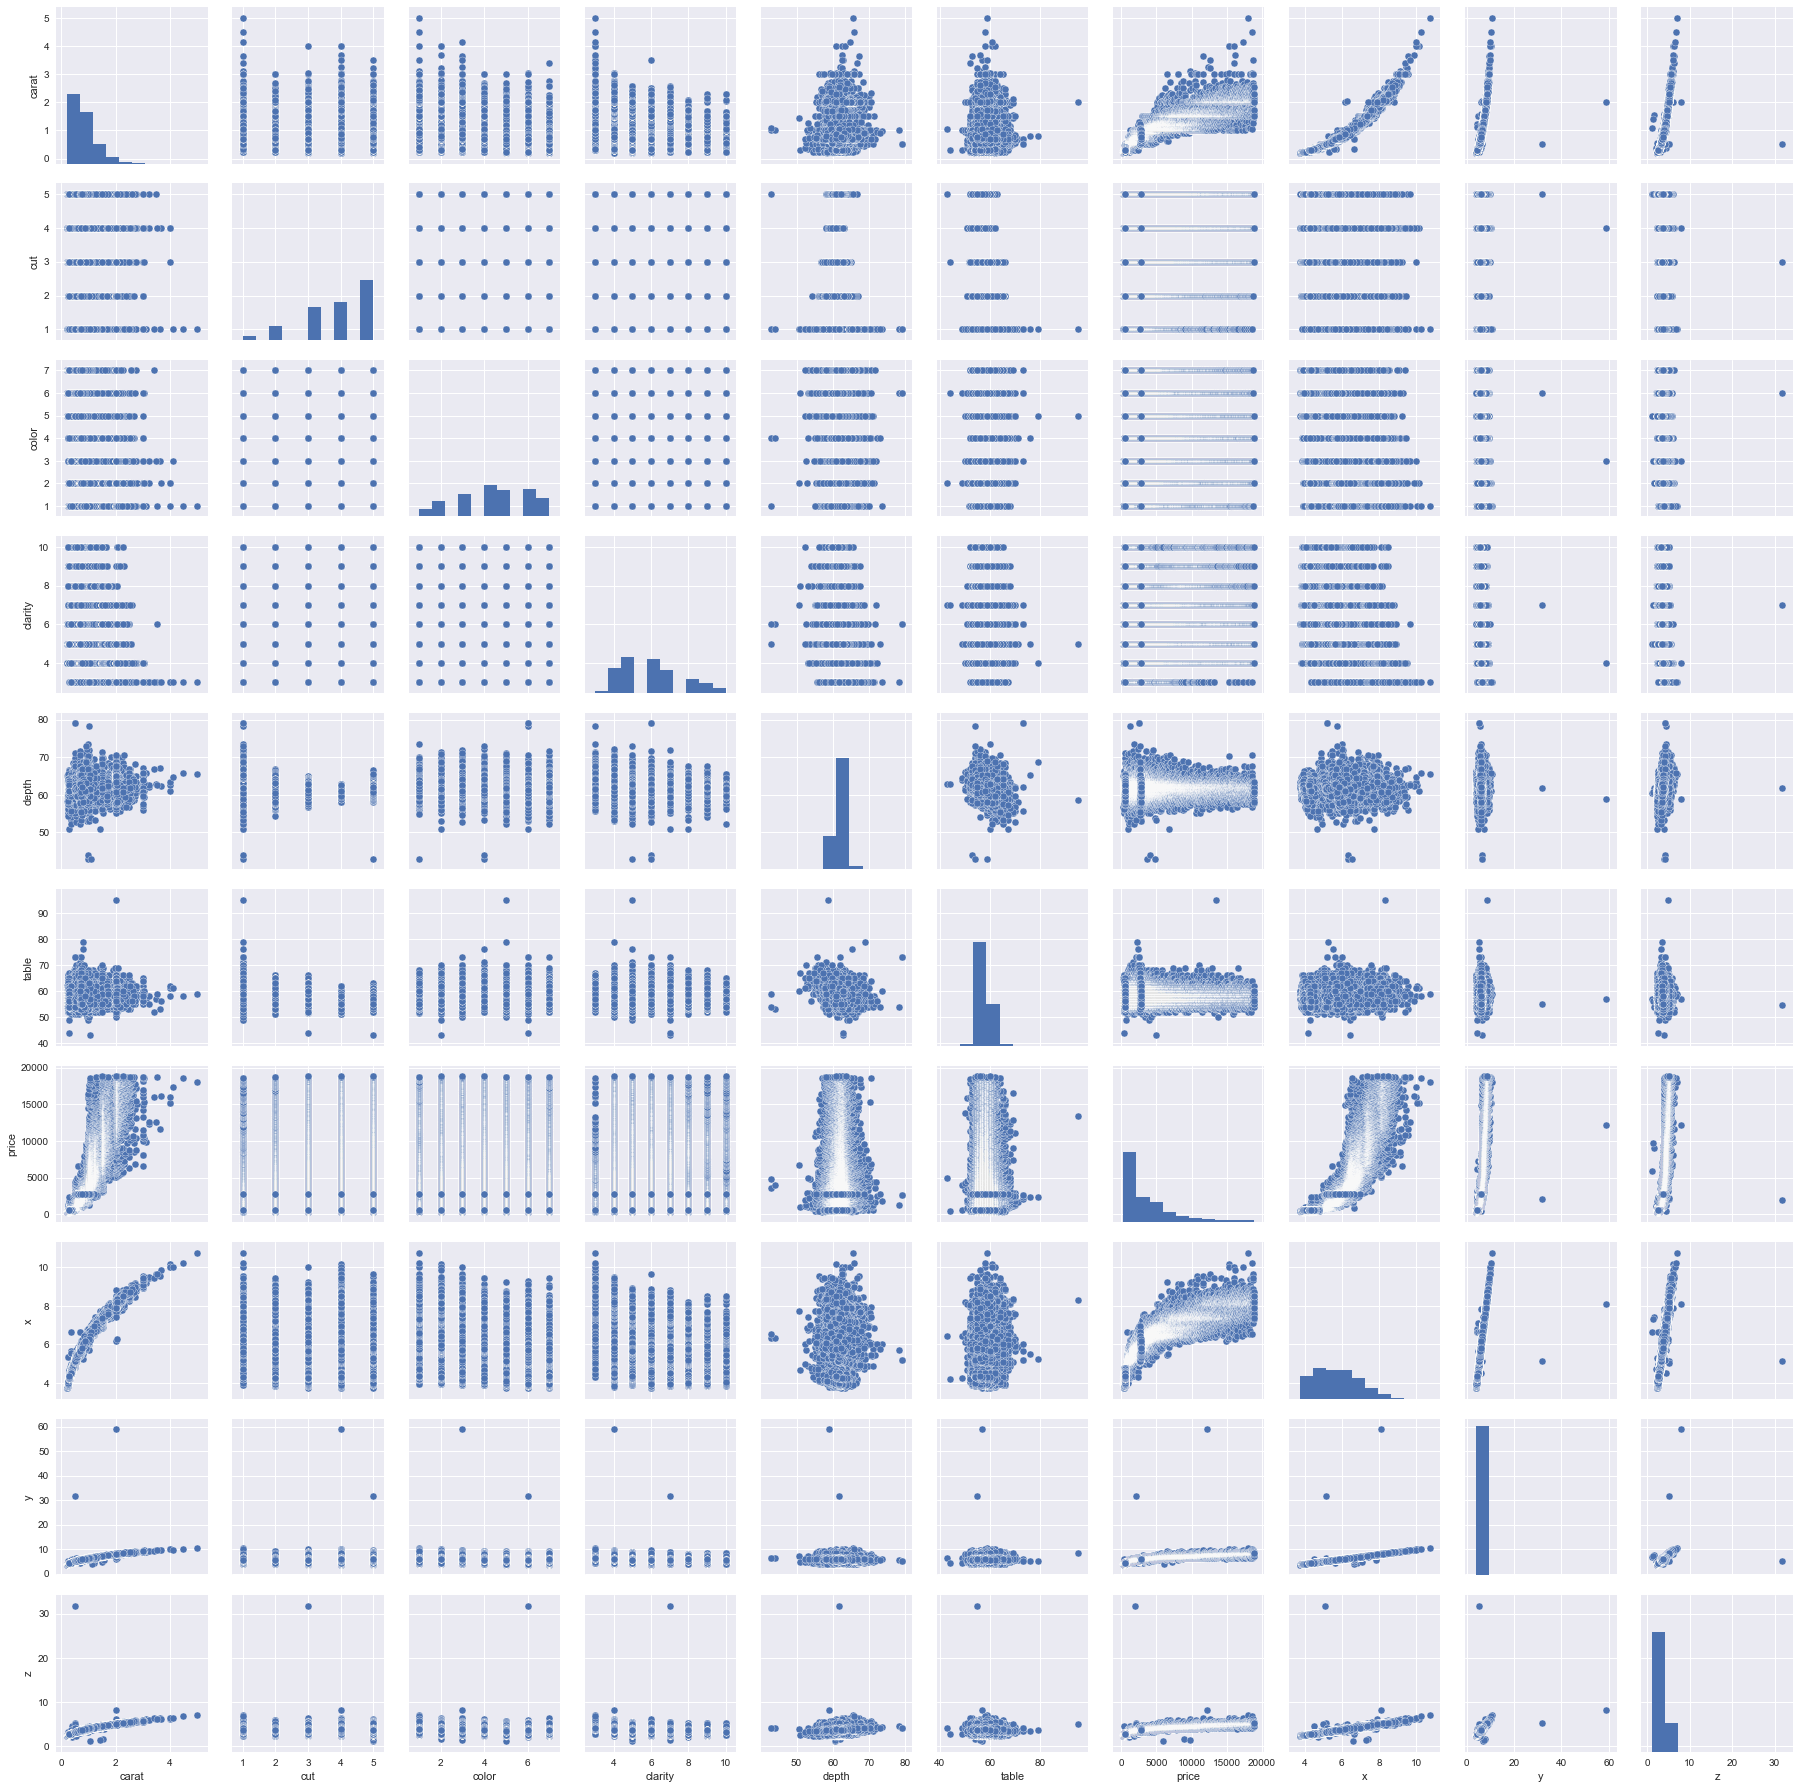

In [100]:
sns.pairplot(diamonds)

###### Price, Carat, X, Y, and Z all have exponential relationships

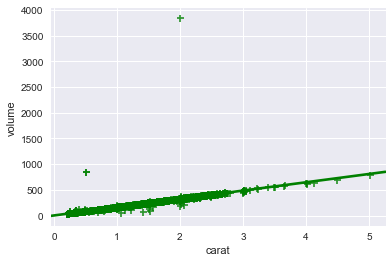

In [101]:
volume = diamonds['x'] * diamonds['y'] * diamonds ['z']
ax = sns.regplot(diamonds['carat'],volume,marker="+", color = 'g')
ax.set_ylabel("volume")

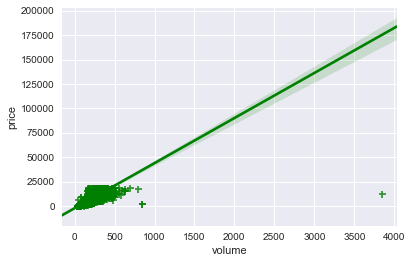

In [102]:
ax = sns.regplot(volume, diamonds['price'],marker="+", color = 'g')
ax.set_xlabel("volume")

#####  Although it is already confirmed that X,Y, and Z have a strong correlation with price, I explored the relation between volumn and price and volumn and carat. Having a volumn replacing X, Y, and Z was definitely a possibility but it didn't improve our model.

In [103]:
#inspect what appears to be an anomaly, diamond has a big volume 
# but low carat value hence low price
diamonds[diamonds['x'] * diamonds['y'] * diamonds ['z'] >= 3500]

,carat,cut,color,clarity,depth,table,price,x,y,z
24063,2.0,4,3,4,58.9,57.0,12210,8.09,58.9,8.06


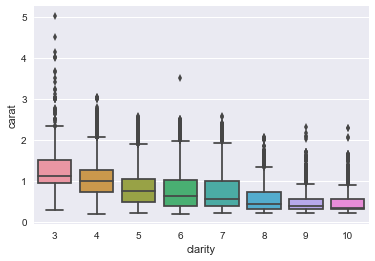

In [104]:
sns.boxplot(x = 'clarity', y = 'carat', data = diamonds)

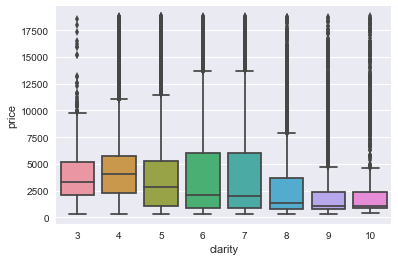

In [105]:
sns.boxplot(x = 'clarity', y = 'price', data = diamonds)

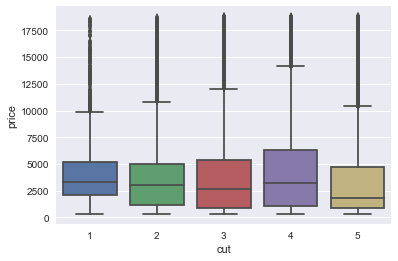

In [106]:
sns.boxplot(x = 'cut', y = 'price', data = diamonds)

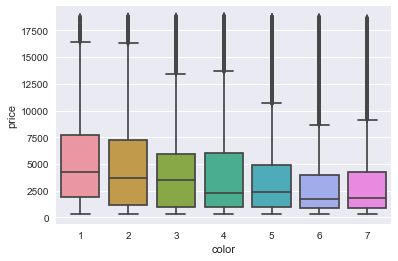

In [107]:
sns.boxplot(x = 'color', y = 'price', data = diamonds)

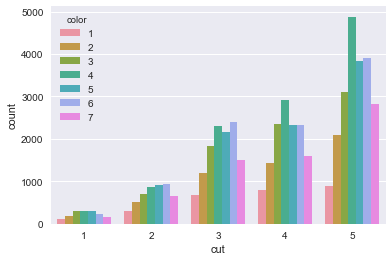

In [108]:
sns.countplot(x = 'cut', hue= 'color', data = diamonds)

#### Takeway here is that there isn't a clear relationship between price and cut/color/clarity. They are still important in our evaluation and in our model but it is other factors that determine the value.

### Conclusion

It is not clear that any features should be dropped. X, Y, Z, and Carat will influence the model the most but Cut, Clarity, and Color are still important. The least important features are Table and Depth (which may be dropped). 

## Modeling <a name="modeling"></a>

$$\begin{align}Model_1: Price = &\theta_0 + \theta_1 \times Carat +  \theta_2 \times Cut \\
&+ \theta_2 \times Cut +  \theta_3 \times Clarity + \theta_4 \\
&+ \times Color + \theta_5 \times X + \theta_6 \times Y  + \theta_7 \times Z
\end{align}$$

In [109]:
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## Linear Regression V1 <a name="m1"></a>

In [110]:
def process_data2(data):
    
    data = data.drop(['table'], axis = 1)
    data = data.drop(['depth'], axis = 1)

    #return predictors and response variables
    X = data.drop(['price'], axis = 1)
    Y = data['price']
    
    return X,Y

In [111]:
#make results reproducible across many notebooks
np.random.seed(1337) 
train, test = train_test_split(diamonds, test_size=0.2)

X_train, y_train = process_data2(train)
X_test, y_test = process_data2(test)

model1 = lm.LinearRegression(fit_intercept=True)
model1.fit(X_train, y_train)

y_fitted = model1.predict(X_train)
y_predicted = model1.predict(X_test)


rsquare = model1.score(X_test,y_test)
print(rsquare)
print('Variance score: %.4f' % r2_score(y_test, y_predicted))

rmse=np.sqrt(mean_squared_error(y_test,y_predicted))
print("rmse: %.4f" %(rmse))

0.902030675617
Variance score: 0.9020
rmse: 1238.3618


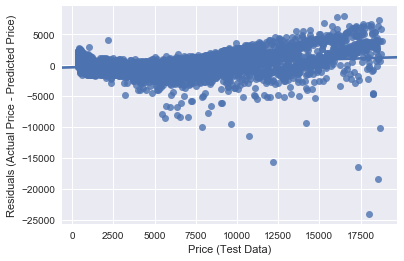

In [112]:
gm1_residuals = y_test - y_predicted
ax = sns.regplot(y_test, gm1_residuals)
ax.set_xlabel('Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

ax = sns.regplot(y_test, y_predicted)
ax.set_ylabel('predicted price')
ax.set_xlabel('actual price')

#### Very straightforward linear model where we take every feature into account except Table and Depth. Model does well but can improve it. 

## Linear Regession V2 <a name="m2"></a>

In [113]:
def process_data3(data):
    
    #remove unwanted columns
    data = data.drop(['table'], axis = 1)
    data = data.drop(['depth'], axis = 1)

 
    #data transformation
    data['carat'] = np.log(data['carat'])
    data['x'] = np.log(data['x'])
    data['y'] = np.log(data['y'])
    data['z'] = np.log(data['z'])
    
    #return predictors and response variables
    # define x and y when passing on the test data without the price column
    X = data
    Y = data
    if 'price' in data:
        X = data.drop(['price'], axis = 1)
        Y = np.log(data['price'])

    return X,Y

In [114]:
from sklearn.model_selection import cross_val_predict
np.random.seed(1337) 
train, test = train_test_split(diamonds, test_size=0.2)

X_train, y_train = process_data3(train)
X_test, y_test = process_data3(test)

model2 = lm.LinearRegression(fit_intercept=True)
model2.fit(X_train, y_train)

y_fitted = model2.predict(X_train)
y_predicted = model2.predict(X_test)


rsquare = model2.score(X_test,y_test)
print(rsquare)

print('Variance score: %.3f' % r2_score(y_test, y_predicted))

rmse=np.sqrt(mean_squared_error(y_test,y_predicted))
print("rmse: %.3f" %(rmse))


0.979602929018
Variance score: 0.980
rmse: 0.145


In [131]:
dX, dy = process_data3(test_diamonds)

In [133]:
v1 = model2.predict(dX)
prices1 = np.exp(v1)
prices1



array([ 1482.50412064,  3310.42520232,  1455.21942535,   557.87889735,
         494.93809716,  2599.71490058,  1700.58881143,  5969.11265386,
         864.87542953,   505.22261452])

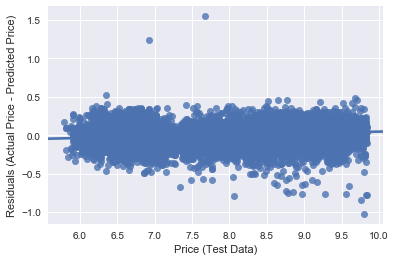

In [117]:
gm1_residuals = y_test - y_predicted
ax = sns.regplot(y_test, gm1_residuals)
ax.set_xlabel('Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

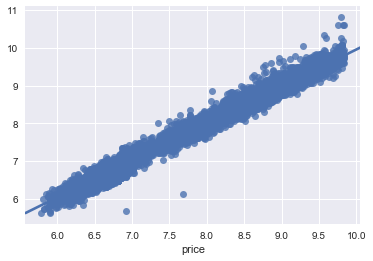

In [118]:
sns.regplot(y_test, y_predicted)
ax.set_ylabel('predicted price')
ax.set_xlabel('actual price')

#### Model 2 does a lot better, greatly improved by again keeping the same columns as Model 1 but this time taking the log of the carat, x, y, and z columns as well as the log of price (for the response variable). Model of course can be improved but it's a simple model that works.

##  Ridge Regression  <a name="ridge"></a>

In [119]:
X_train, y_train = process_data3(train)
X_test, y_test = process_data3(test)

model3 = lm.Ridge(alpha = .09)
model3.fit(X_train, y_train)

y_fitted = model3.predict(X_train)
y_predicted = model3.predict(X_test)


rsquare = model2.score(X_test,y_test)
print(rsquare)

print('Variance score: %.3f' % r2_score(y_test, y_predicted))

rmse = np.sqrt(mean_squared_error(y_test,y_predicted))
print("rmse: %.3f" %(rmse))

0.979602929018
Variance score: 0.980
rmse: 0.145


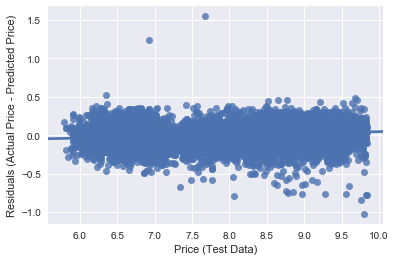

In [120]:
gm1_residuals = y_test - y_predicted
ax = sns.regplot(y_test, gm1_residuals)
ax.set_xlabel('Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')

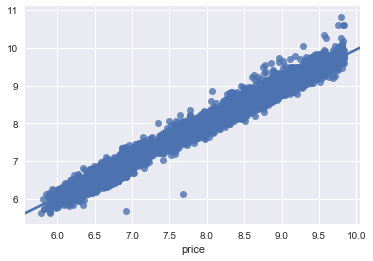

In [121]:
sns.regplot(y_test, y_predicted)
ax.set_ylabel('predicted price')
ax.set_xlabel('actual price')

In [123]:
dX, dy = process_data3(test_diamonds)

In [124]:
v2 = model3.predict(dX)
prices2 = np.exp(v2)
prices2

array([ 1483.11462181,  3310.93967278,  1455.46856418,   558.01757768,
         494.89388412,  2600.51167431,  1700.40476081,  5970.09567135,
         865.0156452 ,   505.33427407])

#### This Model uses Ridge Regression but uses that same Model as model 2. This model does about the same as Model 2. Can improve on this model though by perhaps normalizing columns and cross-validation.

## Results <a name="results"></a>

#### The evaluated prices conclude are those resulting from Model 2

In [ ]:
prices1

In [ ]:
ten = {'carat': [.71, .83, .5, .39, .32, .9, .51, 1.12, .4, .36], 
     'cut': ['Good', 'Ideal', 'Ideal', 'Premium', 'Premium', 'Good', 'Ideal', 'Ideal', 'Ideal', 'Premium'], 
     'color': ['I', 'G', 'E', 'J', 'G', 'F', 'D', 'G', 'G', 'I'],
     'clarity': ['VVS2', 'VS1', 'VS2', 'VS1', 'VS1', 'SI2', 'VS1', 'VVS2', 'VVS2', 'VS2'], 
     'depth': [63.1, 62.1, 61.5, 61.6, 62.1, 63.3, 60.9, 62.1, 62.4, 62.7], 
     'table': [58, 55, 55, 59, 56, 57, 57, 54.8, 56, 59], 
     'x': [5.64, 6.02, 5.11, 4.67, 4.43, 6.08, 5.2, 6.64, 4.72, 4.54], 
     'y': [5.71, 6.05, 5.16, 4.71, 4.4, 6.14, 5.17, 6.66, 4.74, 4.58], 
     'z': [3.58, 3.75, 3.16, 2.89, 2.74, 3.87, 3.16, 4.13, 2.95, 2.86],
     'price': prices1}
               

ten_diamonds = pd.DataFrame(data = ten)
ten_diamonds.to_csv('ten_diamonds.csv', index=False)